In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import math
from tqdm import tqdm
pd.options.display.float_format = '{:5f}'.format
pd.set_option('display.max_columns', 40)

from plotnine import ggplot, aes, geom_line, facet_wrap, facet_grid, theme, element_text, geom_bar, stat_count, geom_point, \
geom_boxplot, geom_jitter, geom_violin, ggtitle, element_blank, scale_y_continuous

from sklearn.preprocessing import LabelEncoder 

import numpy as np

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler 

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek 
from imblearn.under_sampling import TomekLinks 

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, RocCurveDisplay
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics

import xgboost as xgb
from xgboost import XGBClassifier 

In [8]:
# Import data
df_summarised = pd.read_pickle('/aihub/data/raw/final_df/df_overlap_10s_daytime.pkl')
df_summarised.drop(['pcr_result', 'id'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
overlap_cnt_outside,837.000000,38.616487,126.005202,0.000000,0.000000,2.000000,16.000000,1690.000000
overlap_cnt_resi,834.000000,15.063549,63.818335,0.000000,0.000000,0.000000,1.000000,890.000000
overlap_seconds_outside,837.000000,888.983274,2956.469492,0.000000,0.000000,55.000000,374.000000,42044.000000
overlap_seconds_resi,834.000000,303.099520,1355.487092,0.000000,0.000000,0.000000,20.000000,19686.000000
overlap_max_seconds_outside,837.000000,75.587814,199.361207,0.000000,0.000000,21.000000,71.000000,2758.000000
overlap_max_seconds_resi,834.000000,25.412470,77.597076,0.000000,0.000000,0.000000,12.000000,636.000000
overlap_avg_seconds_outside,837.000000,0.326619,0.864859,0.000000,0.000000,0.025068,0.174339,8.267322
overlap_avg_seconds_resi,834.000000,0.274571,0.912541,0.000000,0.000000,0.000000,0.030687,9.445798
overlap_min_seconds_outside,837.000000,9.162485,12.587393,0.000000,0.000000,10.000000,11.000000,147.000000
overlap_min_seconds_resi,834.000000,3.648681,11.148677,0.000000,0.000000,0.000000,10.000000,195.000000


# Preprocessing pipeline

In [9]:
log_YN = 1
outlier_YN = 1
scaling_YN = 0
ADASYN_YN = 0
if ADASYN_YN:
    ROS_YN = 0
else:
    ROS_YN = 1
print('log', log_YN, 'remove_outlier', outlier_YN, 'scailing', scaling_YN, 'ADASYN', ADASYN_YN, 'ROS', ROS_YN)

log 1 remove_outlier 1 scailing 0 ADASYN 0 ROS 1


In [10]:
seed = 1497108
le = LabelEncoder()

#df_mdl = df_summarised_7d.copy()
df_mdl = df_summarised.copy()
#df_mdl = df_plot.copy()
df_mdl.fillna(0, inplace=True)
df_mdl.reset_index(drop=True, inplace=True)
df_mdl['pcr_result'] = df_mdl['pcr_result'].replace(to_replace=[1], value=0)
df_mdl['pcr_result'] = df_mdl['pcr_result'].replace(to_replace=[2], value=1)

X = df_mdl.drop(['pcr_result', 'id'], axis=1)
Y = df_mdl['pcr_result']

if log_YN:
    # Convert x to logarithm
    for col in X.columns:
        X[col] = X[col].map(lambda x: np.log1p(x))
    X.describe()
# Split datasets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y, random_state = 42)
display(x_test)

# remove outliers in x_train
# Calculate IQR
if outlier_YN:
    print(x_train.info())
    x_filtered = x_train.copy()
    for col in x_train.columns:
        Q1 = x_train[col].quantile(0.25)
        Q3 = x_train[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define fences
        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR

        # Filter outliers
        x_filtered = x_filtered[(x_filtered[col] >= lower_fence) & (x_filtered[col] <= upper_fence)]
    print(x_filtered.index)
    y_filtered = y_train.loc[x_filtered.index].to_frame()
    print(x_filtered.shape, y_filtered.shape)
else:
    x_filtered = x_train.copy()
    y_filtered = y_train.copy()

# scaling
if scaling_YN:
    scaler = RobustScaler()
    x_filtered = scaler.fit_transform(x_filtered)
    x_test = scaler.transform(x_test)
    print(scaler.get_feature_names_out(x_train.columns))

# oversampling 1
if ADASYN_YN:
    ada = ADASYN(random_state = 42)
    X_resampled, y_resampled = ada.fit_resample(x_filtered, y_filtered)
    #X_resampled, y_resampled = x_train, y_train
    print(y_resampled.value_counts())

if ROS_YN:    
    # Create a RandomOverSampler object
    ros = RandomOverSampler(sampling_strategy=1, random_state=seed, shrinkage=None)
    # perform oversampling
    X_resampled, y_resampled = ros.fit_resample(x_filtered, y_filtered)

display(X_resampled)
print(y_resampled.value_counts())

,overlap_cnt_outside,overlap_cnt_resi,overlap_seconds_outside,overlap_seconds_resi,overlap_max_seconds_outside,overlap_max_seconds_resi,overlap_avg_seconds_outside,overlap_avg_seconds_resi,overlap_min_seconds_outside,overlap_min_seconds_resi,overlap_location_outside,overlap_people_outside,overlap_people_resi
130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
586,0.693147,2.397895,2.484907,7.255591,2.484907,6.456770,0.023331,1.631223,2.484907,2.397895,0.693147,0.693147,1.098612
247,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
358,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
237,0.000000,1.098612,0.000000,3.044522,0.000000,2.397895,0.000000,0.096228,0.000000,2.397895,0.000000,0.000000,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,3.332205,4.158883,6.188264,6.767343,4.110874,3.218876,0.120173,0.579281,2.397895,2.397895,2.944439,1.098612,0.693147
128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
359,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
323,5.017280,1.609438,7.985825,3.871201,4.828314,2.772589,0.591506,0.078050,2.397895,2.397895,2.397895,1.609438,0.693147


<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 345 to 9
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overlap_cnt_outside          585 non-null    float64
 1   overlap_cnt_resi             585 non-null    float64
 2   overlap_seconds_outside      585 non-null    float64
 3   overlap_seconds_resi         585 non-null    float64
 4   overlap_max_seconds_outside  585 non-null    float64
 5   overlap_max_seconds_resi     585 non-null    float64
 6   overlap_avg_seconds_outside  585 non-null    float64
 7   overlap_avg_seconds_resi     585 non-null    float64
 8   overlap_min_seconds_outside  585 non-null    float64
 9   overlap_min_seconds_resi     585 non-null    float64
 10  overlap_location_outside     585 non-null    float64
 11  overlap_people_outside       585 non-null    float64
 12  overlap_people_resi          585 non-null    float64
dtypes: float64(13)
memor

,overlap_cnt_outside,overlap_cnt_resi,overlap_seconds_outside,overlap_seconds_resi,overlap_max_seconds_outside,overlap_max_seconds_resi,overlap_avg_seconds_outside,overlap_avg_seconds_resi,overlap_min_seconds_outside,overlap_min_seconds_resi,overlap_location_outside,overlap_people_outside,overlap_people_resi
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.098612,0.000000,3.367296,0.000000,2.772589,0.000000,0.015811,0.000000,2.639057,0.000000,0.000000,1.098612
3,2.397895,0.000000,5.808142,0.000000,4.418841,0.000000,0.048947,0.000000,2.397895,0.000000,1.609438,0.693147,0.000000
4,2.944439,0.000000,6.180017,0.000000,4.709530,0.000000,0.227613,0.000000,2.397895,0.000000,2.197225,1.098612,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
688,1.386294,0.000000,4.304065,0.000000,3.912023,0.000000,0.024034,0.000000,2.397895,0.000000,1.386294,1.386294,0.000000
689,1.098612,0.000000,3.258097,0.000000,2.639057,0.000000,0.017813,0.000000,2.564949,0.000000,0.693147,0.693147,0.000000
690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


pcr_result
0             346
1             346
dtype: int64


# Logistic

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Train SEt: Logistic Regression AUC: 0.6488439306358381
[[286  60]
 [183 163]]
0.6488439306358381
0.7309417040358744
0.47109826589595377
0.5729349736379613


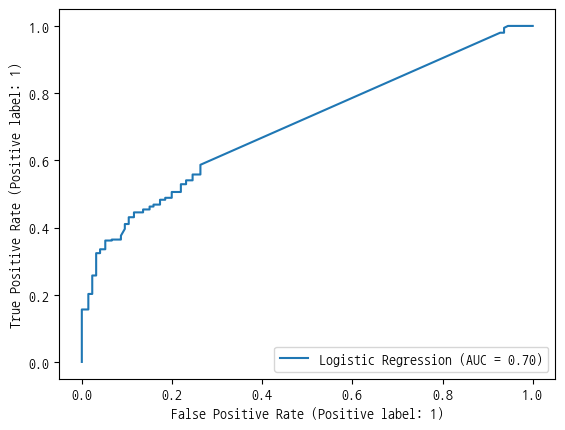

Test Set: Logistic Regression AUC: 0.6308962264150944
[[ 25  15]
 [ 77 135]]
accuracy 0.6349206349206349
recall 0.6367924528301887
specificity 0.625
precision 0.8786687631027255
f1 0.7458563535911603


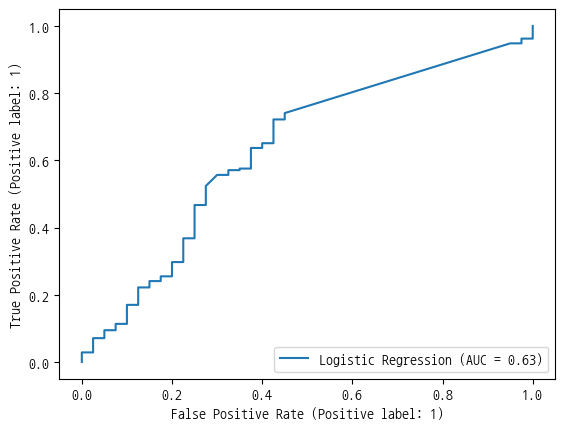

In [47]:
# Logistic
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

lr_model = LogisticRegressionCV(cv = cv, solver = 'liblinear', max_iter = 1000)
lr_model.fit(X_resampled, y_resampled)

if scaling_YN:
    y_pred = lr_model.predict(np.array(X_resampled))
else:
    y_pred = lr_model.predict(X_resampled)
fpr, tpr, thresholds = roc_curve(y_resampled, y_pred, pos_label = 1)
auc = np.trapz(tpr, fpr)
roc_auc = metrics.auc(fpr, tpr)
print('Train SEt: Logistic Regression AUC:', auc)
cm = confusion_matrix(y_resampled, y_pred)
print(cm)
print(metrics.accuracy_score(y_resampled, y_pred))
print(metrics.precision_score(y_resampled, y_pred))
print(metrics.recall_score(y_resampled, y_pred))
print(metrics.f1_score(y_resampled, y_pred))
metrics.RocCurveDisplay.from_estimator(lr_model, X_resampled, y_resampled, name='Logistic Regression')
plt.show()

y_pred = lr_model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
auc = np.trapz(tpr, fpr)
print('Test Set: Logistic Regression AUC:', auc)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(cm)
print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('recall', metrics.recall_score(y_test, y_pred))
print('specificity', specificity)
print('precision', metrics.average_precision_score(y_test, y_pred))
print('f1', metrics.f1_score(y_test, y_pred))

metrics.RocCurveDisplay.from_estimator(lr_model, x_test, y_test, name='Logistic Regression')
plt.show()

In [73]:
lr_model.decision_function

<bound method LinearClassifierMixin.decision_function of LogisticRegressionCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=42),
                     max_iter=1000, solver='liblinear')>

# Random Forest

<ipython-input-68-ea337ee7114c>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=10, max_features=12, max_leaf_nodes=13,
                       min_samples_leaf=7, min_samples_split=5,
                       n_estimators=220, random_state=42)>
Train - RandomForest AUC: 0.7586705202312138
[[325  21]
 [146 200]]
accuracy 0.7586705202312138
precision 0.9049773755656109
recall 0.5780346820809249
f1 0.7054673721340389


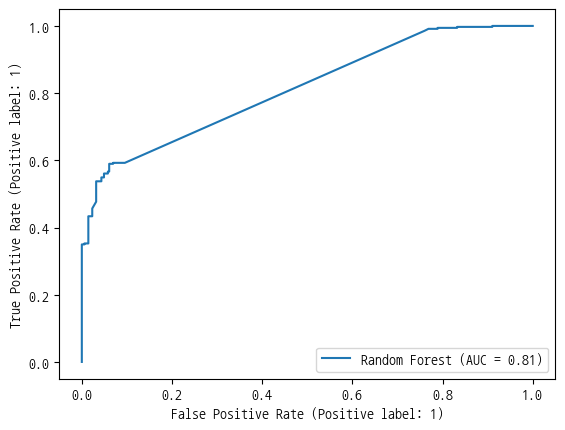

Test - RandomForest AUC: 0.6886792452830188
[[ 30  10]
 [ 79 133]]
accuracy 0.6468253968253969
precision 0.8969793309415951
recall 0.6273584905660378
specificity 0.75
f1 0.7492957746478873


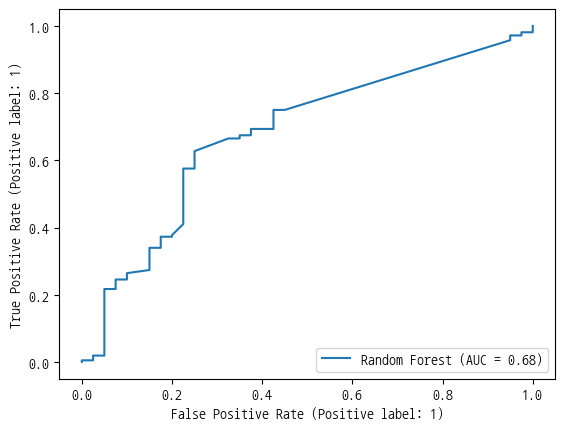

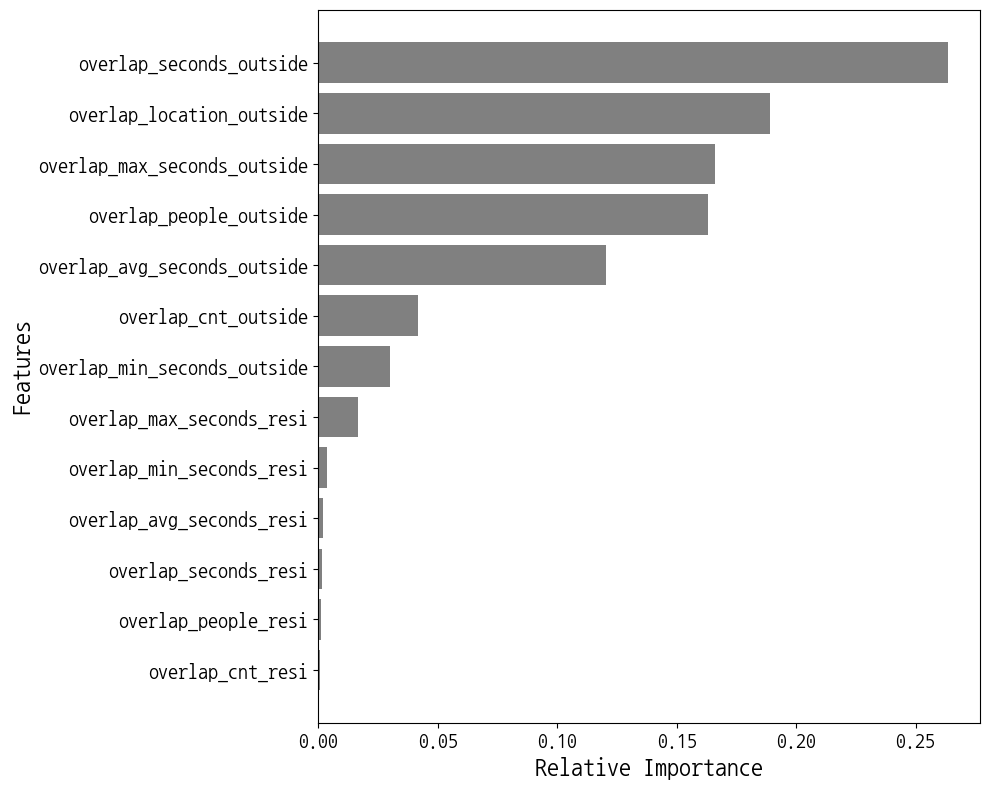

In [68]:
rf_model = RandomForestClassifier(max_depth=10, max_features=12, max_leaf_nodes=13,
                       min_samples_leaf=7, min_samples_split=5,
                       n_estimators=220, random_state=42)

rf_model.fit(X_resampled, y_resampled)

y_pred = rf_model.predict(X_resampled)
fpr, tpr, thresholds = roc_curve(y_resampled, y_pred, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)
print(rf_model.get_params)
print('Train - RandomForest AUC:', roc_auc)
cm = confusion_matrix(y_resampled, y_pred)
print(cm)
print('accuracy', metrics.accuracy_score(y_resampled, y_pred))
print('precision', metrics.precision_score(y_resampled, y_pred))
print('recall', metrics.recall_score(y_resampled, y_pred))
print('f1', metrics.f1_score(y_resampled, y_pred))
metrics.RocCurveDisplay.from_estimator(rf_model, X_resampled, y_resampled, name='Random Forest')
plt.show()

y_pred = rf_model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = metrics.auc(fpr, tpr)
print('Test - RandomForest AUC:', roc_auc)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(cm)
print('accuracy', metrics.accuracy_score(y_test, y_pred))
print('precision', metrics.average_precision_score(y_test, y_pred))
print('recall', metrics.recall_score(y_test, y_pred))
print('specificity', specificity)
print('f1', metrics.f1_score(y_test, y_pred))
metrics.RocCurveDisplay.from_estimator(rf_model, x_test, y_test, name='Random Forest')
plt.show()


# Calculate importance
importances = rf_model.feature_importances_

# Sort attributes by importance
indices = np.argsort(importances)[::]
sorted_features = [x_train.columns[i] for i in indices]

# Importance Plot
plt.figure(figsize=(10, 8))
plt.barh(range(X.shape[1]), importances[indices], color='grey')
plt.yticks(range(X.shape[1]), sorted_features[::])
plt.ylabel("Features", fontsize='xx-large')
plt.xlabel("Relative Importance", fontsize='xx-large')
plt.tick_params(axis='x', labelsize='x-large')
plt.tick_params(axis='y', labelsize='x-large')
plt.tight_layout()
plt.show()

### Importance plot

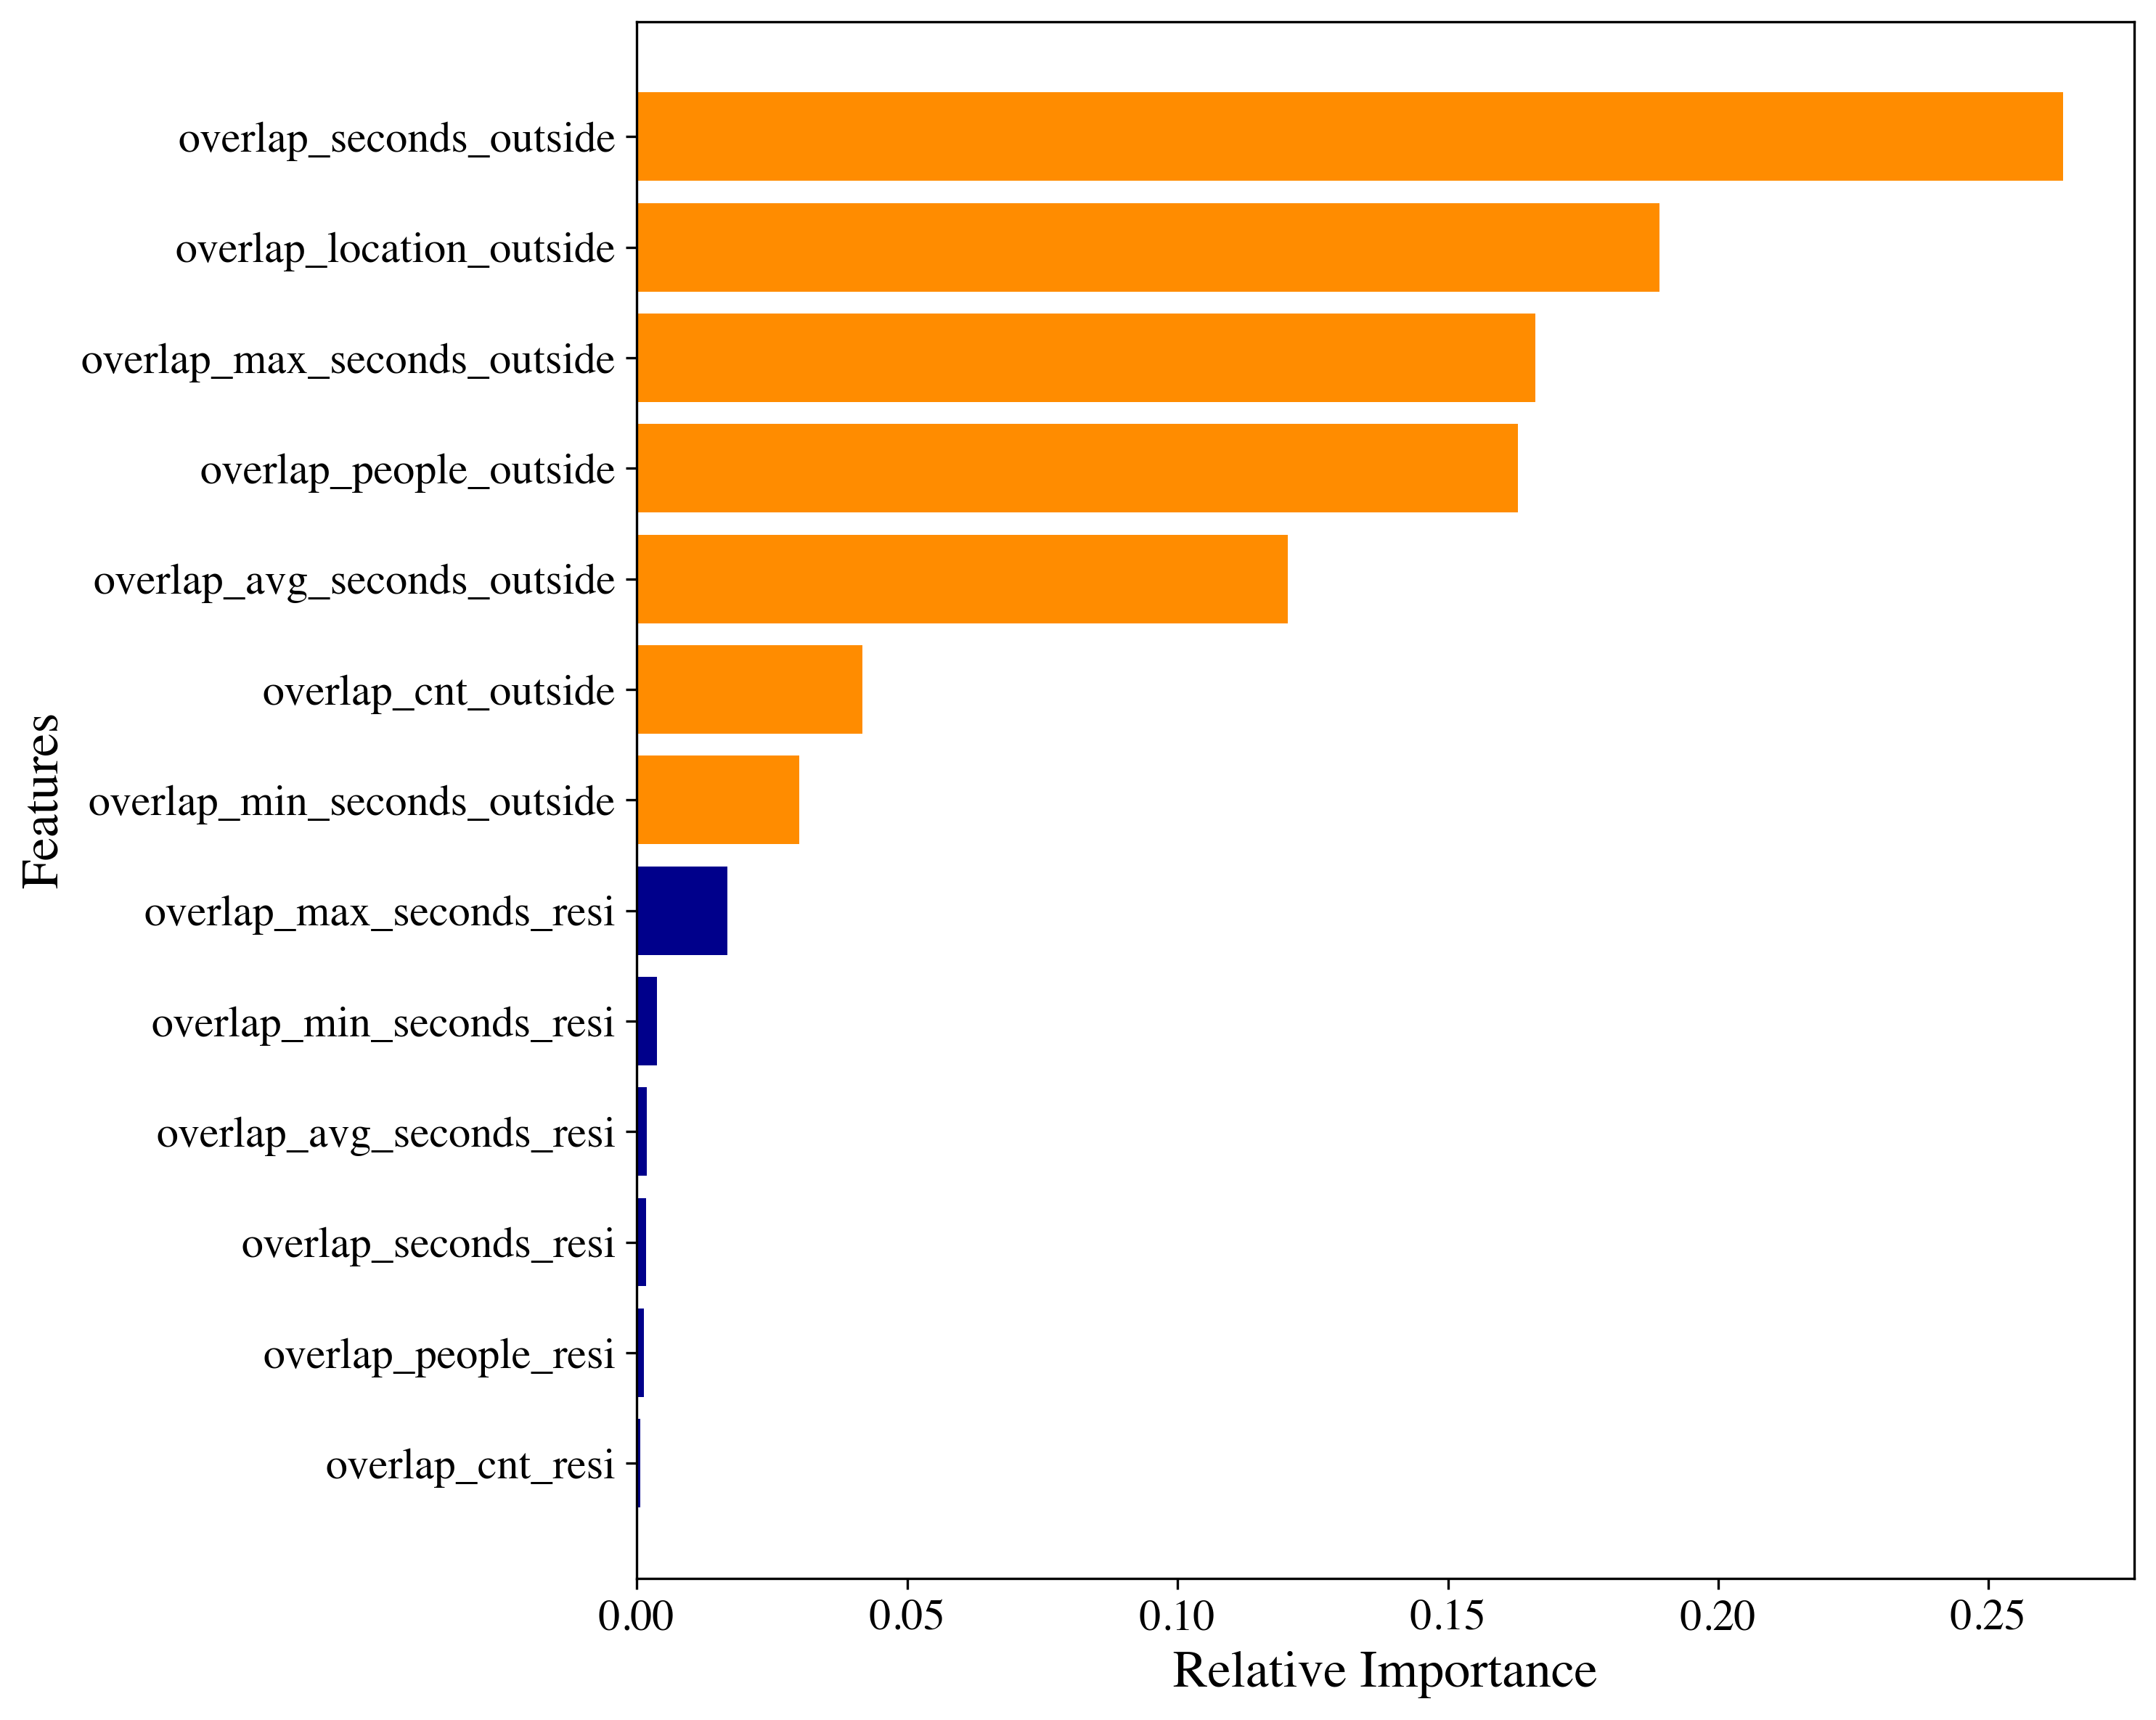

In [19]:
# set font path
font_path = '/aihub/data/Times.ttc'
# register font
fm.fontManager.addfont(font_path)
font_name = fm.fontManager.ttflist[-1].name
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_name

# calculate importance
importances = rf_model.feature_importances_

# Sort attributes by importance
indices = np.argsort(importances)[::]
sorted_features = [x_train.columns[i] for i in indices]
colors = (['darkblue'] * 6) + (['darkorange'] * 8)

plt.figure(figsize=(10, 8), dpi=300)
plt.barh(range(X.shape[1]), importances[indices], color=colors)
plt.yticks(range(X.shape[1]), sorted_features[::])
plt.ylabel("Features", fontsize='xx-large')
plt.xlabel("Relative Importance", fontsize='xx-large')
plt.tick_params(axis='x', labelsize='x-large')
plt.tick_params(axis='y', labelsize='x-large')
plt.tight_layout()
plt.show()

# XGBoost

In [60]:
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
xgb = XGBClassifier()
'''
model = xgb.XGBClassifier(
    learning_rate = 0.01,
    max_depth = 8,
    min_child_weight = 1,
    gamma = 0.1,
    subsample = 0.8,
    colsample_bytree = 0.8,
    scale_pos_weight = 1,
    objective = 'binary:logistic'
)
'''

xgb_param_grid = {
    'n_estimators' : range(200, 310, 10),
    'learning_rate' : [0.1],
    'max_depth' : range(8, 11), 
    'alpha': [0, 0.1], 
    'gamma': [0, 0.1], 
    'lambda': [0, 0.1], 
    'subsample': [0.4, 0.5, 0.6, 0.7, 0.8], 
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8], 
    'min_child_weight': range(1, 9), 
    'objective' : ['binary:logistic']
}

xgb_param_grid_2 = {
    'n_estimators' : range(260, 270),
    'learning_rate' : [0.1],
    'max_depth' : range(8, 10), 
    'alpha': [0, 0.1], 
    'gamma': [0, 0.1], 
    'lambda': [0, 0.1], 
    'subsample': [0.7, 0.8], 
    'colsample_bytree': [0.6, 0.7, 0.8], 
    'min_child_weight': range(5, 9), 
    'objective' : ['binary:logistic']
}

model=GridSearchCV(xgb, param_grid = xgb_param_grid_2, 
                   cv = cv, scoring="roc_auc", n_jobs=-1, verbose = 2)
model.fit(np.array(X_resampled), y_resampled)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=42),
             estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'alpha': [0, 0.1], 'colsample_bytree': [0.6, 0.7, 0.8],
                         'gamma': [0, 0.1], 'lambda': [0, 0.1],
                         'learning_rate': [0.1], 'max_depth': range(8, 10),
                         'min_child_weight': range(5, 9),
                         'n_estimators': range(260, 270),
                         'objective': ['binary:logistic'],
                         'subsample': [0.7, 0.8]},
             scoring='roc_auc', verbose=2)

log 1 remove_outlier 1 scailing 0 ADASYN 0 ROS 1
final parameters <bound method XGBModel.get_xgb_params of XGBClassifier(alpha=0, colsample_bytree=0.7, gamma=0.1, lambda=0, max_depth=8,
              missing=nan, n_estimators=260, subsample=0.8)>
Train - XGBoost AUC: 0.7962427745664741
[[343   3]
 [138 208]]
0.796242774566474
0.985781990521327
0.6011560693641619
0.7468581687612208


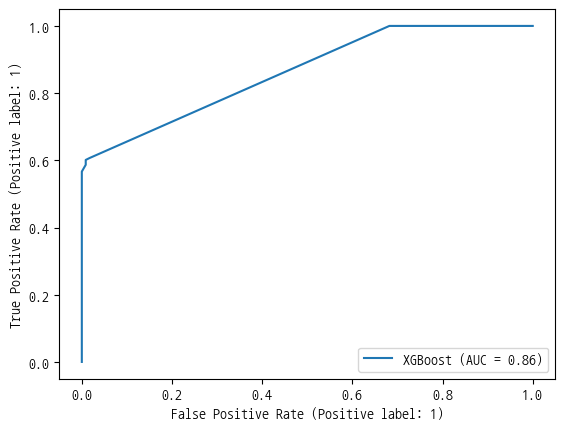

Test - XGBoost AUC: 0.6233490566037736
[[ 21  19]
 [ 59 153]]
accuracy 0.6904761904761905
recall 0.7216981132075472
specificity 0.525
precision 0.8761026313406743
f1 0.7968750000000001


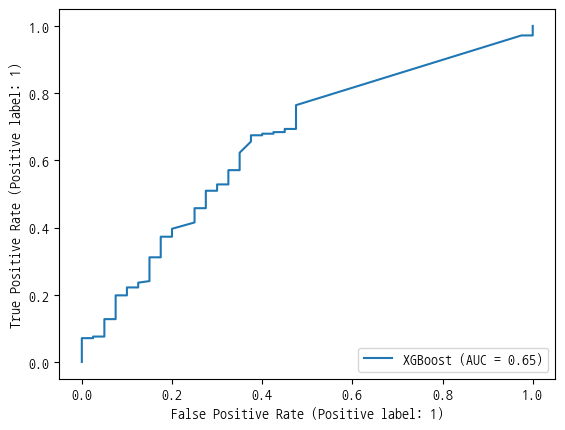

In [63]:
print('log', log_YN, 'remove_outlier', outlier_YN, 'scailing', scaling_YN, 'ADASYN', ADASYN_YN, 'ROS', ROS_YN)
print('final parameters', model.best_estimator_.get_xgb_params)
if scaling_YN:
    y_pred_xg = model.best_estimator_.predict(np.array(X_resampled))
else:
    y_pred_xg = model.best_estimator_.predict(np.array(X_resampled))

fpr_xg, tpr_xg, thresholds = roc_curve(y_resampled, y_pred_xg, pos_label = 1)
roc_auc = metrics.auc(fpr_xg, tpr_xg)
print('Train - XGBoost AUC:', roc_auc)
cm = confusion_matrix(y_resampled, y_pred_xg)
print(cm)
print(metrics.accuracy_score(y_resampled, y_pred_xg))
print(metrics.precision_score(y_resampled, y_pred_xg))
print(metrics.recall_score(y_resampled, y_pred_xg))
print(metrics.f1_score(y_resampled, y_pred_xg))
metrics.RocCurveDisplay.from_estimator(model, np.array(X_resampled), y_resampled, name='XGBoost')
plt.show()

if scaling_YN:
    y_pred_xg = model.best_estimator_.predict(np.array(x_test))
else:
    y_pred_xg = model.best_estimator_.predict(np.array(x_test))
fpr_xg, tpr_xg, thresholds = roc_curve(y_test, y_pred_xg, pos_label = 1)
roc_auc = metrics.auc(fpr_xg, tpr_xg)
print('Test - XGBoost AUC:', roc_auc)
cm = confusion_matrix(y_test, y_pred_xg)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
print(cm)
print('accuracy', metrics.accuracy_score(y_test, y_pred_xg))
print('recall', metrics.recall_score(y_test, y_pred_xg))
print('specificity', specificity)
print('precision', metrics.average_precision_score(y_test, y_pred_xg))
print('f1', metrics.f1_score(y_test, y_pred_xg))
metrics.RocCurveDisplay.from_estimator(model, np.array(x_test), y_test, name='XGBoost')
plt.show()

# Save the model file

In [65]:
import pickle

with open('/aihub/data/mdl/xgboost_auc0655.pkl', 'wb') as f:
    # xgboost
    pickle.dump(model, f)
with open('/aihub/data/mdl/logistic_auc0634.pkl', 'wb') as f:
    # logistic
    pickle.dump(lr_model, f)
with open('/aihub/data/mdl/rf_auc0679.pkl', 'wb') as f:
    # xgboost
    pickle.dump(rf_model, f)

# Final Plotting

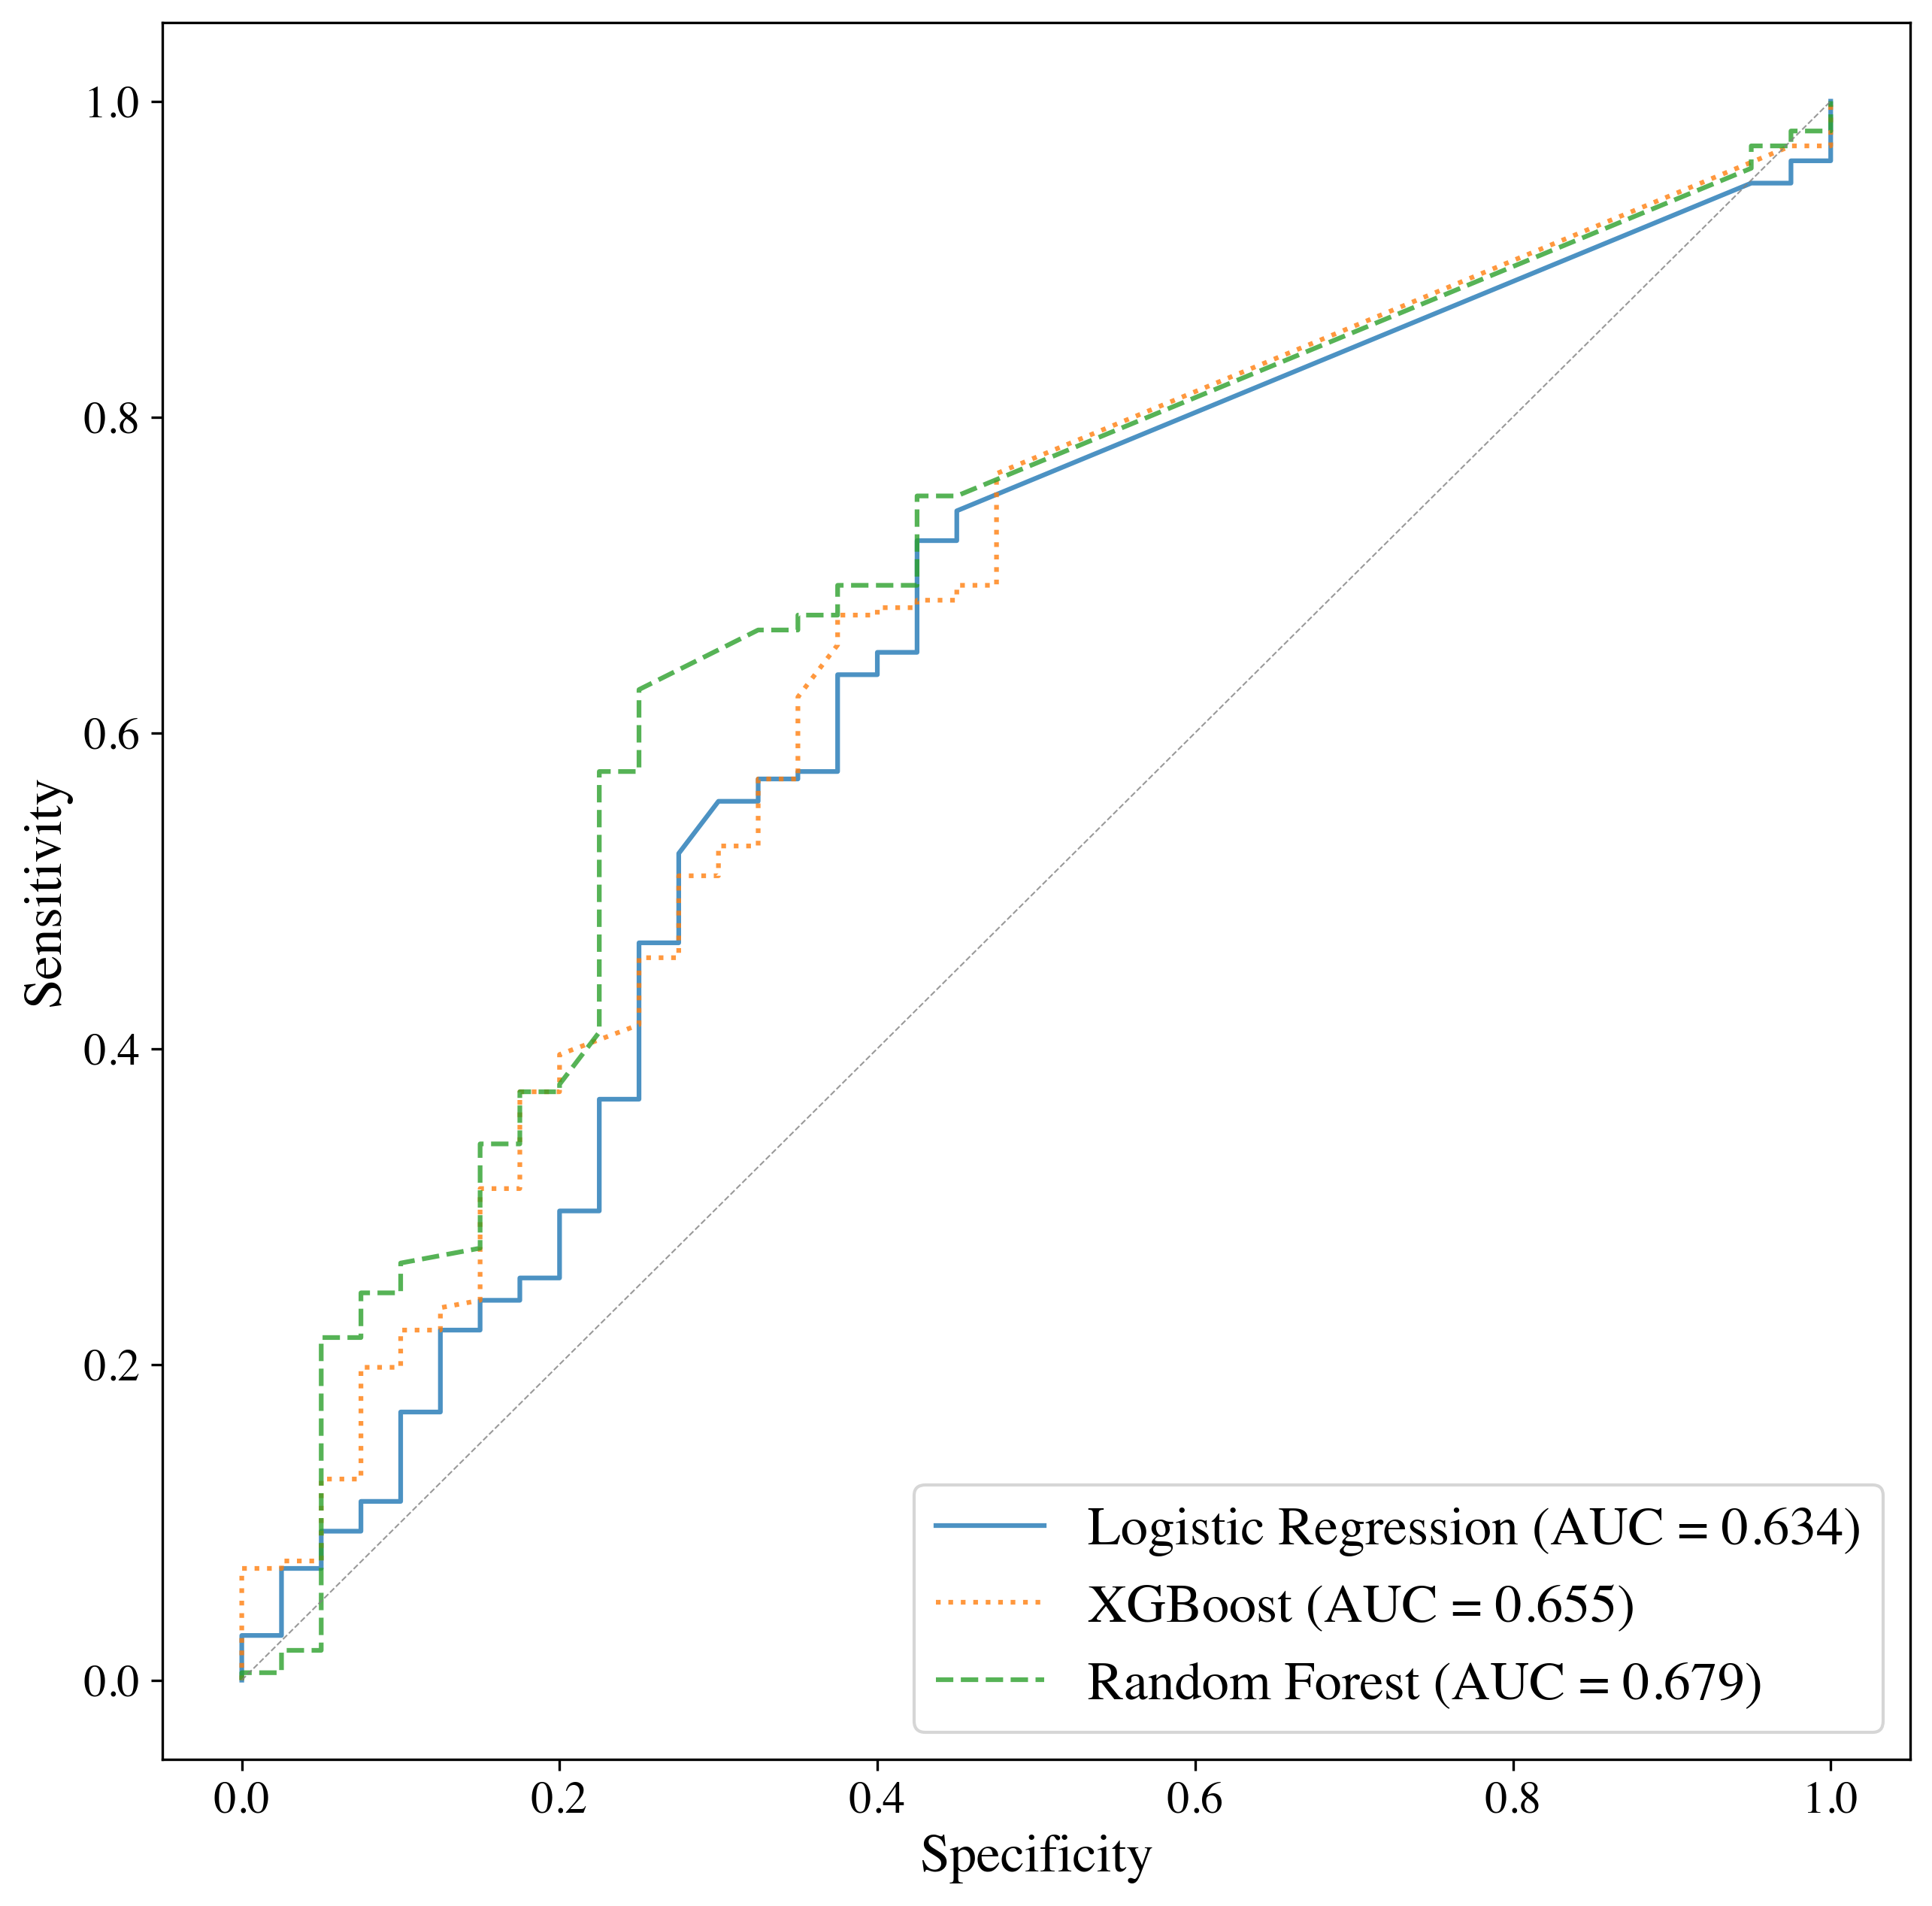

In [24]:
# fig, ax = plt.subplots()
# rfc_disp = RocCurveDisplay.from_estimator(lr_model, x_test, y_test, ax=ax, alpha=0.8, name='Logistic Regression')
# xgboost_disp = RocCurveDisplay.from_estimator(model, np.array(x_test), y_test, name='XGBoost')
# rf_disp = RocCurveDisplay.from_estimator(rf_model, x_test, y_test, name='Random Forest')
# rf_disp.plot(ax=ax, alpha=0.8)
# plt.show()


estimators = {
    'Logistic Regression': lr_model,
    'XGBoost': model, 
    'Random Forest': rf_model
}

linestyles = {
    'Logistic Regression': 'solid',
    'Random Forest': 'dashed',
    'XGBoost': 'dotted'
}
plt.figure(figsize=(10, 10), dpi=300)
for name, estimator in estimators.items():
    if name == 'XGBoost':
        fpr, tpr, _ = roc_curve(y_test, estimator.predict_proba(np.array(x_test))[:, 1])
    else:
        fpr, tpr, _ = roc_curve(y_test, estimator.predict_proba(x_test)[:, 1])
    # calculate AUC
    roc_auc = metrics.auc(fpr, tpr)
    # format the AUC to 3 decimal places and add it to the legend
    plt.plot(fpr, tpr, linestyle=linestyles[name], label=f'{name} (AUC = {roc_auc:.3f})', alpha=.8)

# Add a plot label and legend
import matplotlib.font_manager as fm  
# set font
font_path = '/aihub/data/Times.ttc' 
fm.fontManager.addfont(font_path)
font_name = fm.fontManager.ttflist[-1].name
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_name

plt.plot([0, 1], [0, 1], linestyle='--', lw=.5, color='gray', alpha=.8)
plt.xlabel('Specificity', fontsize='xx-large', fontname=font_name)
plt.ylabel('Sensitivity', fontsize='xx-large', fontname=font_name)
plt.tick_params(axis='x', labelsize='x-large')
plt.tick_params(axis='y', labelsize='x-large')
plt.xticks(fontname=font_name)
plt.yticks(fontname=font_name)
plt.legend(loc='lower right', fontsize='xx-large')
plt.show()